# 关注公众号【Python读财】，选择“星标”公众号，重磅干货，第一时间送达

![](https://upload-images.jianshu.io/upload_images/8316927-0fb816f497f6e7f5.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

# 导包和数据

In [1]:
pip install pyecharts -U

Requirement already up-to-date: pyecharts in d:\anaconda3\lib\site-packages (1.8.1)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyecharts.charts.basic_charts import pie    # 原代码：from pyecharts.charts import Pie
from pyecharts import options as opts
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('white',{'font.sans-serif':['simhei','Arial']})
pd.set_option("display.max_column", None)
pd.set_option("display.max_row",None)

In [2]:
path = "./lagou.csv"
df = pd.read_csv(path)

In [3]:
df.columns

Index(['Unnamed: 0', '_id', 'adWord', 'appShow', 'approve', 'businessZones',
       'city', 'companyFullName', 'companyId', 'companyLabelList',
       'companyLogo', 'companyShortName', 'companySize', 'createTime',
       'deliver', 'district', 'education', 'explain', 'financeStage',
       'firstType', 'formatCreateTime', 'gradeDescription', 'hitags',
       'imState', 'industryField', 'industryLables', 'isHotHire',
       'isSchoolJob', 'jobNature', 'lastLogin', 'latitude', 'linestaion',
       'longitude', 'pcShow', 'plus', 'positionAdvantage', 'positionId',
       'positionLables', 'positionName', 'promotionScoreExplain',
       'publisherId', 'resumeProcessDay', 'resumeProcessRate', 'salary',
       'score', 'secondType', 'skillLables', 'stationname', 'subwayline',
       'thirdType', 'workYear', 'job_detail'],
      dtype='object')

In [4]:
# 取出我们进行后续分析所需的字段
columns = ["positionName", "companyShortName", "city", "companySize", "education", "financeStage",
           "industryField", "salary", "workYear", "hitags", "companyLabelList", "job_detail"]
df = df[columns].drop_duplicates() #去重
# df

# 分析目标
- 各城市对数据分析岗位的需求情况
- 不同细分领域对数据分析岗的需求情况
- 数据分析岗位的薪资状况
- 工作经验与薪水的关系
- 公司都要求什么掌握什么技能
- 岗位的学历要求高吗
- 不同规模的企业对工资经验的要求以及提供的薪资水平

# 数据清洗

## 去掉非数据分析岗的数据

In [5]:
# 原始数据长度
len(df)

2939

In [6]:
# 数据分析相应的岗位数量
cond_1 = df["positionName"].str.contains("数据分析")  # 职位名中含有数据分析字眼的
cond_2 = ~df["positionName"].str.contains("实习")  # 剔除掉带实习字眼的
len(df[cond_1 & cond_2]["positionName"])

1326

In [7]:
# 筛选出我们想要的字段，并剔除positionName
df = df[cond_1 & cond_2]
df.drop(["positionName"], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

## 将拉勾网的薪水转化为数值
拉勾网爬取下来的薪水是一个区间，这里用薪水区间的均值作为相应职位的薪水

In [8]:
# 处理过程
#1、将salary中的字符串均小写化（因为存在8k-16k和8K-16K）
#2、运用正则表达式提取出薪资区间
#3、将提取出来的数字转化为int型
#4、取区间的平均值
df["salary"] = df["salary"].str.lower()\
               .str.extract(r'(\d+)[k]-(\d+)k')\
               .applymap(lambda x:int(x))\
               .mean(axis=1)

## 从job_detail中提取出技能要求
将技能分为以下几类：
- Python/R
- SQL
- Tableau
- Excel

处理方式：
如果job_detail中含有上述四类，则赋值为1，不含有则为0

In [9]:
df["job_detail"] = df["job_detail"].str.lower().fillna("")  #将字符串小写化，并将缺失值赋值为空字符串

df["Python/R"] = df["job_detail"].map(lambda x:1 if ('python' in x) or ('r' in x) else 0)
df["SQL"] = df["job_detail"].map(lambda x:1 if ('sql' in x) or ('hive' in x)  else 0)
df["Tableau"] = df["job_detail"].map(lambda x:1 if 'tableau' in x  else 0)
df["Excel"] = df["job_detail"].map(lambda x:1 if 'excel' in x  else 0)

In [10]:
df.head(1)

,companyShortName,city,companySize,education,financeStage,industryField,salary,workYear,hitags,companyLabelList,job_detail,Python/R,SQL,Tableau,Excel
0,达达-京东到家,北京,2000人以上,本科,D轮及以上,消费生活,22.5,3-5年,"['免费班车', '新婚红包', '定期调薪', '电脑补贴', '生子红包', '地铁周边...","['年底双薪', '绩效奖金', '岗位晋升', '定期体检']","1 、负责o2o电商日常运营数据的统计, 监控, 梳理指标体系；||2、基于海量用户行为数据...",1,1,0,1


## 处理行业信息

In [11]:
def clean_industry(industry):
    industry = industry.split(",")
    if industry[0]=="移动互联网" and len(industry)>1:
        return industry[1]
    else:
        return industry[0]

df["industryField"] = df.industryField.map(clean_industry)

# 数据分析

## 各城市对数据分析岗位的需求量

Text(0, 0.5, '')

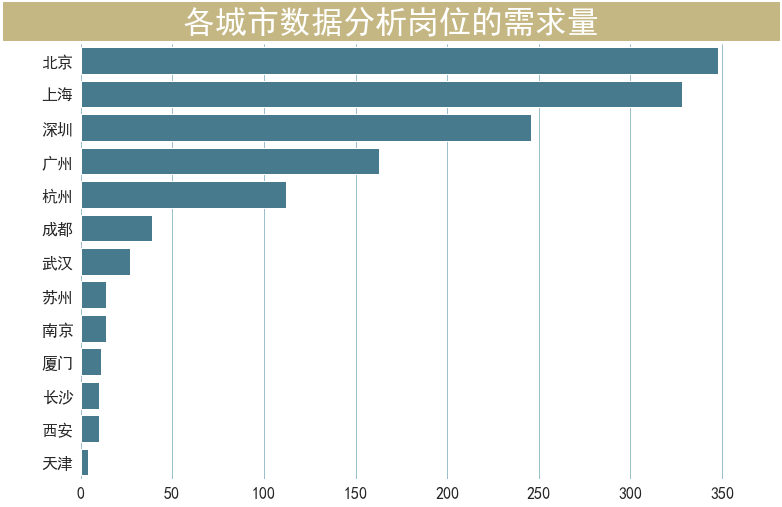

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(y="city",order= df["city"].value_counts().index,data=df,color='#3c7f99')
plt.box(False)
fig.text(x=0.04, y=0.90, s='           各城市数据分析岗位的需求量           ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel('')
plt.ylabel('')

## 不同细分领域对数据分析岗的需求量

In [24]:
industry_index = df["industryField"].value_counts()[:10].index
industry =df.loc[df["industryField"].isin(industry_index),"industryField"]

Text(0, 0.5, '')

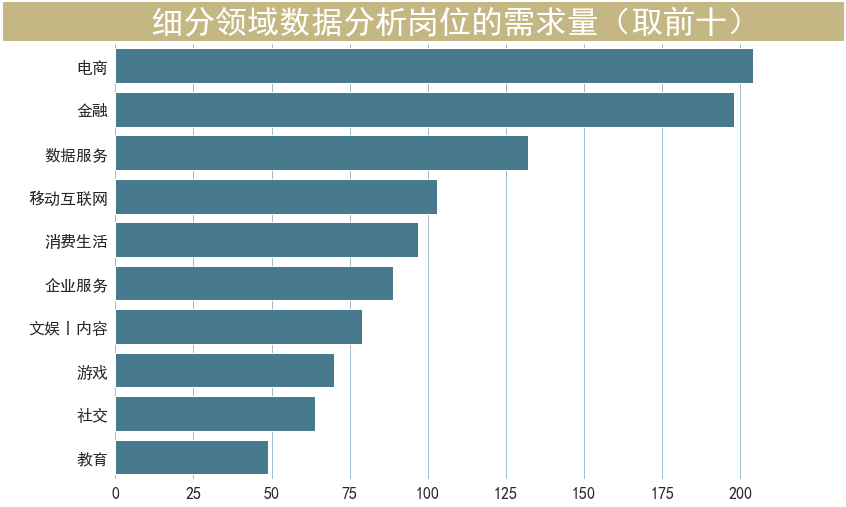

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(y=industry.values,order = industry_index,color='#3c7f99')
plt.box(False)
fig.text(x=0, y=0.90, s='         细分领域数据分析岗位的需求量（取前十）     ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel('')
plt.ylabel('')

## 各城市相应岗位的薪资状况

Text(0, 0.5, '')

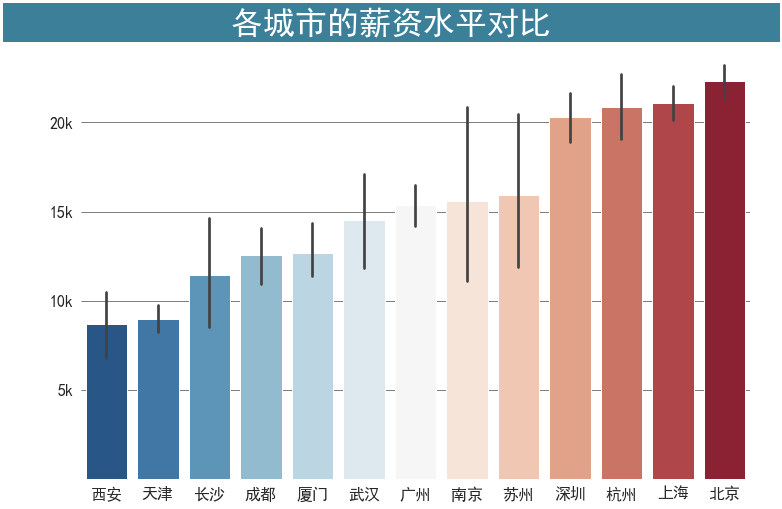

In [33]:
fig,ax = plt.subplots(figsize=(12,8))
city_order = df.groupby("city")["salary"].mean()\
               .sort_values()\
               .index.tolist()
sns.barplot(x="city", y="salary", order=city_order, data=df, ci=95,palette="RdBu_r")
fig.text(x=0.04, y=0.90, s='              各城市的薪资水平对比              ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#3c7f99')
plt.tick_params(axis="both",labelsize=16,)
ax.yaxis.grid(which='both', linewidth=0.5, color='black')
ax.set_yticklabels([" ","5k","10k","15k","20k"])
plt.box(False)
plt.xlabel('')
plt.ylabel('')

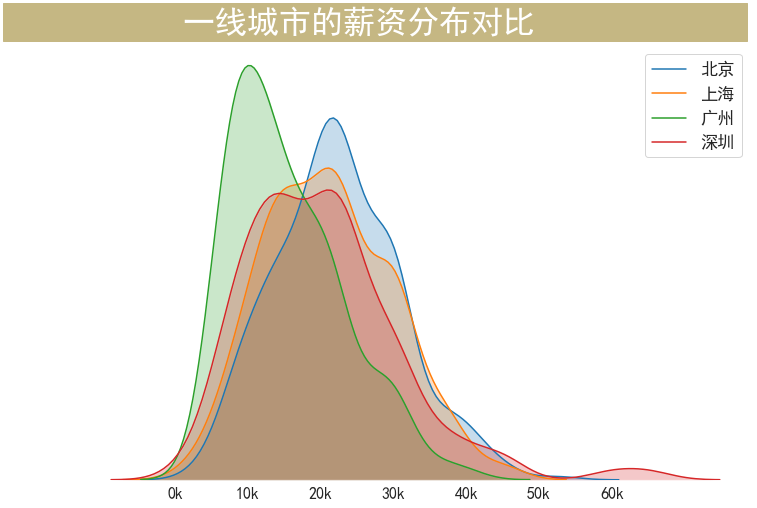

In [39]:
fig,ax = plt.subplots(figsize=(12,8))
fig.text(x=0.04, y=0.90, s='           一线城市的薪资分布对比             ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
sns.kdeplot(df[df["city"]=='北京']["salary"],shade=True,label="北京")
sns.kdeplot(df[df["city"]=='上海']["salary"],shade=True,label="上海")
sns.kdeplot(df[df["city"]=='广州']["salary"],shade=True,label="广州")
sns.kdeplot(df[df["city"]=='深圳']["salary"],shade=True,label="深圳")
plt.tick_params(axis='both', which='major', labelsize=16)
plt.box(False)
plt.xticks(np.arange(0,61,10), [str(i)+"k" for i in range(0,61,10)])
plt.yticks([])
plt.legend(fontsize = 'xx-large',fancybox=None)

## 工作经验与薪水的关系

In [40]:
corr = df.pivot_table(index="city",columns="workYear",values="salary")

In [41]:
corr = corr[["应届毕业生","1-3年","3-5年","5-10年"]]

In [42]:
corr.loc[city_order]

workYear,应届毕业生,1-3年,3-5年,5-10年
city,,,,
西安,12.000000,6.250000,11.000000,NaN
天津,NaN,8.500000,9.000000,NaN
长沙,NaN,10.500000,11.000000,18.250000
成都,10.500000,9.500000,15.833333,18.333333
厦门,10.000000,11.375000,14.400000,NaN
武汉,9.000000,6.666667,17.300000,22.250000
广州,8.727273,10.915094,18.508621,24.800000
南京,12.500000,11.625000,21.000000,NaN
苏州,NaN,10.583333,20.750000,30.000000


(Text(0.5, 51.34375, ''), Text(69.078125, 0.5, ''))

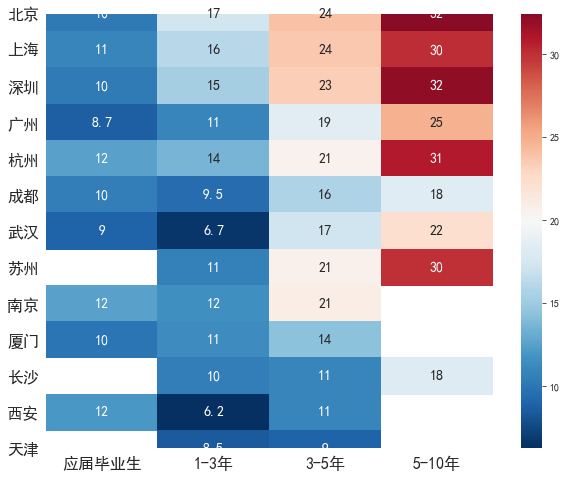

In [43]:
fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr.loc[df["city"].value_counts().index],cmap="RdBu_r",center=20,annot=True,annot_kws={'fontsize':14})
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16,labelrotation=0)
plt.xlabel(""),plt.ylabel("")

## 技能要求

In [44]:
py_rate = df["Python/R"].value_counts(normalize=True).loc[1]
sql_rate = df["SQL"].value_counts(normalize=True).loc[1]
tableau_rate = df["Tableau"].value_counts(normalize=True).loc[1]
excel_rate = df["Excel"].value_counts(normalize=True).loc[1]
print("职位技能需求：")
print("Python/R：",py_rate)
print("SQL：",sql_rate)
print("Excel：",excel_rate)
print("Tableau：",tableau_rate)

职位技能需求：
Python/R： 0.6078431372549019
SQL： 0.6070889894419306
Excel： 0.3310708898944193
Tableau： 0.09502262443438914


![玉玦图（线形）.jpg](https://upload-images.jianshu.io/upload_images/8316927-8344a996af4e0f83.jpg?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


In [45]:
def get_level(x):
    if x["Python/R"] == 1:
        x["skill"] = "Python/R"
    elif x["SQL"] == 1:
        x["skill"] = "SQL"
    elif x["Excel"] == 1:
        x["skill"] = "Excel"
    else:
        x["skill"] = "其他"
    return x

In [46]:
df = df.apply(get_level,axis=1)

Text(0, 0.5, '技能')

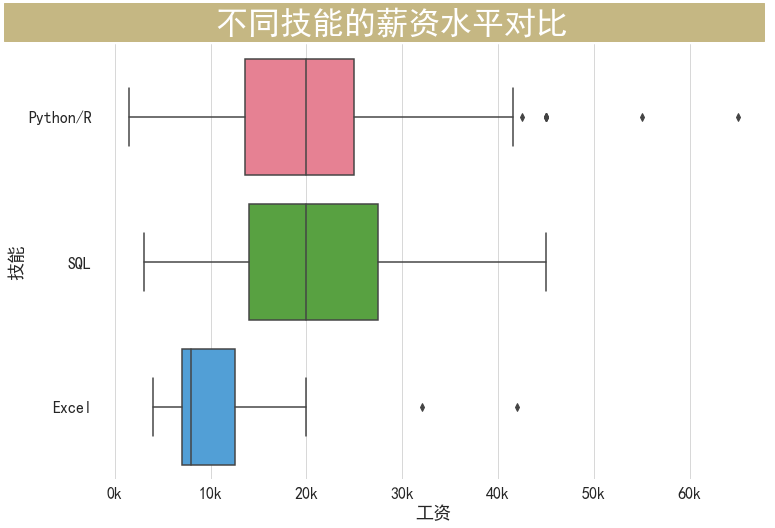

In [47]:
fig,ax = plt.subplots(figsize=(12,8))
fig.text(x=0.02, y=0.90, s='             不同技能的薪资水平对比            ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
sns.boxplot(y="skill",x="salary",data=df.loc[df.skill!="其他"],palette="husl",order=["Python/R","SQL","Excel"])
plt.tick_params(axis="both",labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.75)
plt.xticks(np.arange(0,61,10), [str(i)+"k" for i in range(0,61,10)])
plt.box(False)
plt.xlabel('工资', fontsize=18)
plt.ylabel('技能', fontsize=18)

## 学历要求

In [48]:
education = df["education"].value_counts(normalize=True)

In [54]:
from pyecharts.commons.utils import JsCode
def new_label_opts():
        return opts.LabelOpts(formatter=JsCode("学历要求"))
pie = (
    Pie().add(
        "",
        [list(z) for z in zip(education.index, np.round(education.values,4))],
        center=["50%", "50%"],
        radius=["50%","75%"],
        label_opts=new_label_opts()
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title=""),
        legend_opts=opts.LegendOpts(
                is_show=False
            )
    )
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%")))

TypeError: 'module' object is not callable

In [50]:
pie.render_notebook()

AttributeError: module 'pyecharts.charts.basic_charts.pie' has no attribute 'render_notebook'

## 不同规模的公司在招人要求上的差异

In [55]:
company_size_map = {
    "2000人以上": 6,
    "500-2000人": 5,
    "150-500人": 4,
    "50-150人": 3,
    "15-50人": 2,
    "少于15人": 1
}
workYear_map = {
    "5-10年": 5,
    "3-5年": 4,
    "1-3年": 3,
    "1年以下": 2,
    "应届毕业生": 1
}
df["company_size"] = df["companySize"].map(company_size_map)
df["work_year"] = df["workYear"].map(workYear_map)

In [56]:
df = df.sort_values(by="company_size",ascending=True)

In [57]:
df_plot = df.loc[~df.work_year.isna()]

In [58]:
color_map = {
    5:"#ff0000",
    4:"#ffa500",
    3:"#c5b783",
    2:"#3c7f99",
    1:"#0000cd"
}
df_plot["color"] = df_plot.work_year.map(color_map)
df_plot.reset_index(drop=True,inplace=True)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
def seed_scale_plot():
    seeds=np.arange(5)+1
    y=np.zeros(len(seeds),dtype=int)
    s=seeds*100
    colors=['#ff0000', '#ffa500', '#c5b783', '#3c7f99', '#0000cd'][::-1] 
    fig,ax=plt.subplots(figsize=(12,1))
    plt.scatter(seeds,y,s=s,c=colors,alpha=0.3)
    plt.scatter(seeds,y,c=colors)
    plt.box(False)
    plt.grid(False)
    plt.xticks(ticks=seeds,labels=list(workYear_map.keys())[::-1],fontsize=14)
    plt.yticks(np.arange(1),labels=['  经验：'],fontsize=16)

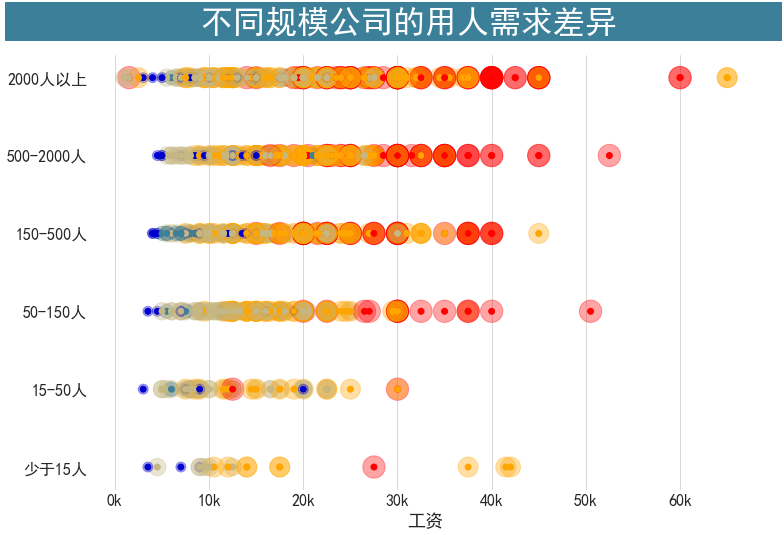

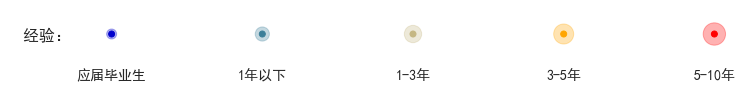

In [60]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.text(x=0.03, y=0.92, s='            不同规模公司的用人需求差异          ', fontsize=32, 
         weight='bold', color='white', backgroundcolor='#3c7f99')
plt.scatter(df_plot.salary, df_plot["companySize"],  s=df_plot["work_year"]*100 ,alpha=0.35,c=df_plot["color"])
plt.scatter(df_plot.salary, df_plot["companySize"], c=df_plot["color"].values.tolist())
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.75)
plt.xticks(np.arange(0,61,10), [str(i)+"k" for i in range(0,61,10)])
plt.xlabel('工资', fontsize=18)
plt.box(False)
seed_scale_plot()

In [61]:
df_skill = df.loc[(df["companySize"]=="2000人以上")&(df.skill!="其他")]["skill"].value_counts(normalize=True)

In [62]:
df_skill

Python/R    0.760234
SQL         0.178363
Excel       0.061404
Name: skill, dtype: float64

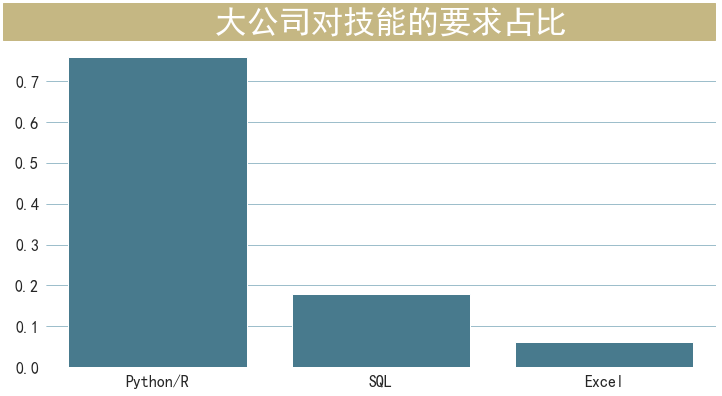

In [63]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=df_skill.index,y=df_skill.values, color='#3c7f99')
plt.box(False)

fig.text(x=0.08, y=0.9, s='             大公司对技能的要求占比         ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
